In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
p = sns.color_palette()

USE_SAMPLE = False
TRAIN_FACE = './sample/train_face.txt' if USE_SAMPLE else './data/train_face.txt'
TRAIN_USER_INTERACT = './sample/train_interaction.txt' if USE_SAMPLE else './data/train_interaction.txt'
TRAIN_TEXT = './sample/train_text.txt' if USE_SAMPLE else './data/train_text.txt'
TEST_FACE = './sample/test_face.txt' if USE_SAMPLE else './data/test_face.txt'
TEST_INTERACT = './sample/test_interaction.txt' if USE_SAMPLE else './data/test_interaction.txt'
TEST_TEXT = './sample/test_text.txt' if USE_SAMPLE else './data/test_text.txt'
col_feature_store_path = './sample/features/columns' if USE_SAMPLE else './data/features/columns'

In [2]:
face_train = pd.read_csv(TRAIN_FACE, 
                        sep='\t', 
                        header=None, 
                        names=['photo_id', 'faces'])

In [3]:
user_item_train = pd.read_csv(TRAIN_USER_INTERACT, 
                             sep='\t', 
                             header=None, 
                             names=['user_id', 'photo_id', 'click', 'like', 'follow', 'time', 'playing_time', 'duration_time'])

In [4]:
text_train = pd.read_csv(TRAIN_TEXT,
                       sep='\t',
                       header=None,
                       names=['photo_id', 'cover_words'])

In [5]:
face_test = pd.read_csv(TEST_FACE, 
                        sep='\t', 
                        header=None, 
                        names=['photo_id', 'faces'])

In [6]:
user_item_test = pd.read_csv(TEST_INTERACT, 
                             sep='\t', 
                             header=None, 
                             names=['user_id', 'photo_id', 'time', 'duration_time'])

In [7]:
text_test = pd.read_csv(TEST_TEXT,
                       sep='\t',
                       header=None,
                       names=['photo_id', 'cover_words'])

In [8]:
alpha = 2.5171267342473382
beta = 7.087836849232511

In [9]:
ctr = alpha/(alpha+beta)
ctr

0.2620652033055799

# 图片被用户浏览数据分布

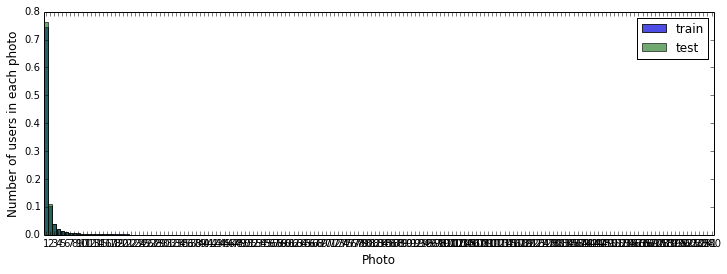

In [10]:
sizes_train = user_item_train.groupby('photo_id')['user_id'].count().value_counts()
sizes_test = user_item_test.groupby('photo_id')['user_id'].count().value_counts()
sizes_train = sizes_train / np.sum(sizes_train)
sizes_test = sizes_test / np.sum(sizes_test)

plt.figure(figsize=(12,4))
sns.barplot(sizes_train.index, sizes_train.values, alpha=0.8, color=p[0], label='train')
sns.barplot(sizes_test.index, sizes_test.values, alpha=0.6, color=p[1], label='test')
plt.legend()
plt.xlabel('Photo', fontsize=12)
plt.ylabel('Number of users in each photo', fontsize=12)

# 图片文本分类 
由于文字数据集是全的，通过对图片文字描述的分类，可以挖掘图片的隐含语义信息，从而对图片进行分类，可以利用这些分类信息，完成图片id的编码


In [10]:
text_data = pd.concat([text_train, text_test])

text_data['photo_id'].nunique()
def words_to_list(words):
        if words == '0':
            return []
        else:
            return words.split(',')
        
text_data['cover_words'] = text_data['cover_words'].apply(words_to_list)
text_data['cover_length'] = text_data['cover_words'].apply(lambda words: len(words))

text_data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 5174532 entries, 0 to 895845
Data columns (total 3 columns):
photo_id        int64
cover_words     object
cover_length    int64
dtypes: int64(2), object(1)
memory usage: 157.9+ MB


In [11]:
text_data.head(20)

,photo_id,cover_words,cover_length
0,1711318,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",196
1,2758458,"[278, 279, 280, 281, 282, 24, 283, 284, 285, 2...",190
2,5314019,"[359, 360, 361, 362, 363, 364, 365, 366, 33, 3...",210
3,5735948,"[508, 509, 510, 511, 512, 508, 513, 514, 515, ...",154
4,3161504,"[549, 74, 550, 14, 551, 551, 279, 552, 553, 55...",812
5,1457390,"[0, 735, 164, 736, 76, 737, 738, 739, 0, 738, ...",48
6,55956,"[8, 324, 93, 73, 491, 74, 93, 73, 14, 742, 12,...",190
7,1035274,"[351, 789, 356, 33, 79, 61, 198, 790, 14, 791,...",154
8,2284079,"[8, 324, 93, 73, 491, 74, 93, 73, 14, 742, 12,...",189
9,2228409,"[8, 324, 93, 73, 491, 74, 93, 73, 14, 742, 12,...",189


In [12]:
text_data[(text_data['cover_length']==1) & (text_data['cover_words'] is [0])]

,photo_id,cover_words,cover_length


In [13]:
no_text_photo_ids = list(text_data[text_data['cover_length']==0]['photo_id'].unique())

In [14]:
len(no_text_photo_ids)

2641712

In [23]:
text_photo_ids = list(text_data[text_data['cover_length']>0]['photo_id'].unique())

In [24]:
len(text_photo_ids)

2532820

In [49]:
text_train = text_data.iloc[:text_train.shape[0]]
text_test = text_data.iloc[text_train.shape[0]:]
text_train_photo_ids = list(text_train[text_train['cover_length']>0]['photo_id'].unique())
text_test_photo_ids = list(text_test['photo_id'].unique())
no_text_train_photo_ids = list(text_train[text_train['cover_length']==0]['photo_id'].unique())
no_text_test_photo_ids = list(text_test[text_test['cover_length']==0]['photo_id'].unique())

In [54]:
interaction_train_photo_ids = list(user_item_train['photo_id'].unique())
user_item_train['photo_id'].nunique()

4278686

In [55]:
interaction_test_photo_ids = list(user_item_test['photo_id'].unique())
user_item_test['photo_id'].nunique()

895846

In [39]:
face_train_photo_ids = list(face_train['photo_id'].unique())
face_test_photo_ids = list(face_test['photo_id'].unique())

In [40]:
interaction_photo_ids = set(interaction_train_photo_ids + interaction_test_photo_ids)
len(interaction_photo_ids)

5174532

In [51]:
all_text_train_photo_ids = set(text_train_photo_ids + no_text_train_photo_ids)
len(all_text_train_photo_ids)

4278686

In [53]:
all_text_test_photo_ids = set(text_test_photo_ids + no_text_test_photo_ids)
len(all_text_test_photo_ids)

895846

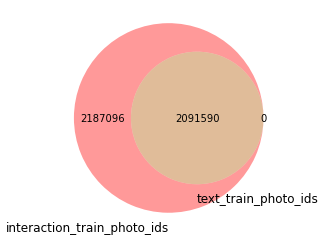

In [41]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
plt.figure(figsize=(4, 4))
venn2([set(interaction_train_photo_ids), set(text_train_photo_ids)], ['interaction_train_photo_ids', 'text_train_photo_ids'])
plt.show()

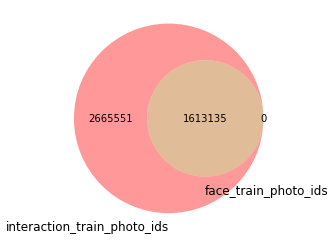

In [43]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
plt.figure(figsize=(4, 4))
venn2([set(interaction_train_photo_ids), set(face_train_photo_ids)], ['interaction_train_photo_ids', 'face_train_photo_ids'])
plt.show()

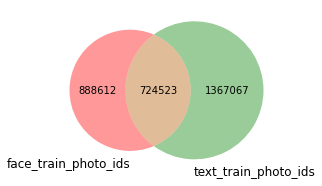

In [42]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
plt.figure(figsize=(4, 4))
venn2([set(face_train_photo_ids), set(text_train_photo_ids)], ['face_train_photo_ids', 'text_train_photo_ids'])
plt.show()

上面三个图是关于线下数据的，并不是所有的线下数据集图片都有文本描述，线上数据的文本，人脸都只有部分图片有，然后带人脸和文本的也只有部分交叉，但是大部分带人脸的都有文本描述，888612 幅图带人脸的有724523有文本描述。而在线上数据集，所有带人脸的图片都有文本描述，且所有图片都有文本描述。

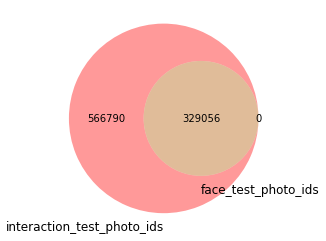

In [47]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
plt.figure(figsize=(4, 4))
venn2([set(interaction_test_photo_ids), set(face_test_photo_ids)], ['interaction_test_photo_ids', 'face_test_photo_ids'])
plt.show()

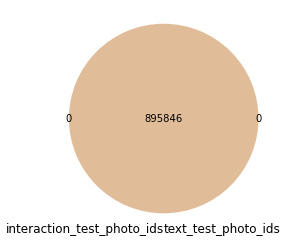

In [45]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
plt.figure(figsize=(4, 4))
venn2([set(interaction_test_photo_ids), set(text_test_photo_ids)], ['interaction_test_photo_ids', 'text_test_photo_ids'])
plt.show()

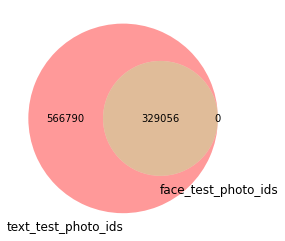

In [48]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
plt.figure(figsize=(4, 4))
venn2([set(text_test_photo_ids), set(face_test_photo_ids)], ['text_test_photo_ids', 'face_test_photo_ids'])
plt.show()

上面三个图可以看到，所有的线上数据都包含文本描述，部分包含人脸，即在线上数据中所有包含人脸的数据都是有文本描述的

## 图片文本分类模型
对于图片的文本数据，我们可以通过不同的模型学习和分类图片，首先由文档有两类表示方法，tfidf 和 word2vec/doc2vec, 然后我们可以采用不同的模型进行聚类（隐含语义分类）或者做分类（二分01点击），可以使用K-means,LDA等进行聚类，也可以用 SVM/LR/GBDT等进行分类，最后尝试LSTM深度学习。

### 模型输入数据表征
#### word2vec

In [11]:
num_features = 128
min_word_count = 40
num_workers = 4
context = 6
downsampling = 1e-3

from gensim.models import word2vec
import os
model = None
model_name = "%dfeatures_%dminwords_%dcontext.model" % (num_features, min_word_count, context)
model_name = model_name + ".sample" if USE_SAMPLE else model_name
if not os.path.exists(model_name):
    print "Training model..."
    model = word2vec.Word2Vec(text_data.cover_words,
                              workers=num_workers,
                              size=num_features,
                              min_count = min_word_count,
                              window = context,
                              sample = downsampling)
    model.init_sims(replace=True)
    model.save(model_name)

model = word2vec.Word2Vec.load(model_name)

Training model...


In [20]:
model.most_similar("0")

/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('1828', 0.602296769618988),
 ('1526', 0.5761873722076416),
 ('3390', 0.572670042514801),
 ('1516', 0.5605823993682861),
 ('3392', 0.5523289442062378),
 ('3178', 0.5438832640647888),
 ('4895', 0.5339459180831909),
 ('1908', 0.525124192237854),
 ('10702', 0.5236855745315552),
 ('3378', 0.5225512981414795)]

In [13]:
print(model.corpus_count)
print(len(set(model.wv.index2word)))

1337176
8005


#### doc2vec

In [14]:
import numpy as np  # Make sure that numpy is imported

def makeFeatureVec(model, num_features, words):
    featureVec = np.zeros((num_features,),dtype="float64")
    nwords = 0
    # set for fast query
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords*1.0)
    return featureVec


def getAvgFeatureVecs(covers, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(covers),num_features),dtype="float64")
    for cover in covers:
        if counter%100000 == 0:
            print "Cover %d of %d" % (counter, len(covers))
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(cover, model, \
           num_features)
        # Increment the counter
        counter = counter + 1
    return reviewFeatureVecs

In [15]:
import functools
doc2vec = functools.partial(makeFeatureVec, model, num_features)
text_data['doc_vec'] = text_data['cover_words'].apply(doc2vec)

/Library/Python/2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [22]:
text_data.head()

,photo_id,cover_words,cover_length,doc_vec
0,5735948,"[508, 509, 510, 511, 512, 508, 513, 514, 515, ...",154,"[-0.025878702781887516, -0.047330769046244246,..."
1,1035274,"[351, 789, 356, 33, 79, 61, 198, 790, 14, 791,...",154,"[-0.017359135672450066, -0.0212560188619123, -..."
2,5752571,"[1158, 1159, 1160, 1158, 1159, 1160, 1161, 116...",189,"[-0.01641334203929551, -0.009614278170369608, ..."
3,473617,"[1294, 173, 1295, 1296, 14, 1297, 150, 1298, 1...",35,"[0.0024094040409716614, 0.019040408003253535, ..."
4,1040170,"[1474, 1475, 1476, 1477, 1478, 1479, 1480, 148...",18,"[-0.00876109438416149, 0.0368937700654247, 0.0..."


In [23]:
f = 'text_data_docvec'
f = f + '.sample.csv' if USE_SAMPLE else f + '.csv'
text_data['doc_vec'].to_csv(f)

另一种方法是先使用Kmeans对所有的单词做聚类，这可以看成无监督学习出来隐含空间的文本特征属性，每一个类代表一个维度的特征，然后统计一个文本中的单词都属于哪些类的词频作为对应维度的特征值，构成一个DocVector；

这里对文本进行分类可以直接采用得到的Doc2Vec对文本进行聚类，聚类之后，每一个photo就具有类别属性，可以对photo进行编码。

前面的是直接将词向量简单的做平均来构造一个文档的向量DocVector, 当然也可以乘以tf-idf权重。


In [ ]:
USER_FEATURE_TRAIN_FILE = 'user_feature_train'
USER_FEATURE_TRAIN_FILE = USER_FEATURE_TRAIN_FILE + '_sample.csv' if USE_SAMPLE else USER_FEATURE_TRAIN_FILE + '.csv'
user_item_train = pd.read_csv(USER_FEATURE_TRAIN_FILE, sep='\t')

USER_FEATURE_TEST_FILE = 'user_feature_test'
USER_FEATURE_TEST_FILE = USER_FEATURE_TEST_FILE + '_sample.csv' if USE_SAMPLE else USER_FEATURE_TEST_FILE + '.csv'
user_item_test = pd.read_csv(USER_FEATURE_TEST_FILE, sep='\t')

In [23]:
text_data.head()

,photo_id,cover_words,cover_length
0,5735948,"[508, 509, 510, 511, 512, 508, 513, 514, 515, ...",154
1,1035274,"[351, 789, 356, 33, 79, 61, 198, 790, 14, 791,...",154
2,5752571,"[1158, 1159, 1160, 1158, 1159, 1160, 1161, 116...",189
3,473617,"[1294, 173, 1295, 1296, 14, 1297, 150, 1298, 1...",35
4,1040170,"[1474, 1475, 1476, 1477, 1478, 1479, 1480, 148...",18


In [24]:
text_data.shape

(1337176, 3)

In [25]:
print(text_data.iloc[0]['cover_words'])

['508', '509', '510', '511', '512', '508', '513', '514', '515', '516', '517', '287', '14', '518', '508', '9', '519', '520', '510', '93', '521', '522', '508', '523', '524', '525', '526', '508', '193', '527', '528', '529', '530', '10', '508', '531', '511', '515', '532', '533', '522', '508', '509', '515', '74', '534', '535', '536', '508', '537', '510', '538', '508', '539', '540', '515', '516', '62', '541', '508', '542', '510', '543', '508', '544', '515', '74', '89', '545', '508', '254', '546', '547', '510', '546', '287', '548', '508', '509', '510', '511', '512', '508', '513', '514', '515', '516', '517', '287', '14', '518', '508', '9', '519', '520', '510', '93', '521', '522', '508', '523', '524', '525', '526', '508', '193', '527', '528', '529', '530', '10', '508', '531', '511', '515', '532', '533', '522', '508', '509', '515', '74', '534', '535', '536', '508', '537', '510', '538', '508', '539', '540', '515', '516', '62', '541', '508', '542', '510', '543', '508', '544', '515', '74', '89', '5

In [26]:
print(text_data.iloc[1]['cover_words'])

['351', '789', '356', '33', '79', '61', '198', '790', '14', '791', '745', '198', '258', '14', '246', '9', '792', '317', '228', '793', '24', '794', '795', '423', '796', '18', '356', '689', '797', '795', '423', '798', '18', '356', '799', '800', '801', '749', '802', '803', '146', '41', '74', '804', '805', '806', '29', '73', '14', '726', '87', '150', '73', '14', '807', '808', '787', '809', '14', '198', '167', '810', '811', '770', '76', '812', '813', '770', '76', '814', '795', '287', '137', '239', '815', '287', '816', '351', '789', '356', '33', '79', '61', '198', '790', '14', '791', '745', '198', '258', '14', '246', '9', '792', '317', '228', '793', '24', '794', '795', '423', '796', '18', '356', '689', '797', '795', '423', '798', '18', '356', '799', '800', '801', '749', '802', '803', '146', '41', '74', '804', '805', '806', '29', '73', '14', '726', '87', '150', '73', '14', '807', '808', '787', '809', '14', '198', '167', '810', '811', '770', '76', '812', '813', '770', '76', '814', '795', '287'

In [27]:
print(text_data.iloc[2]['cover_words'])

['1158', '1159', '1160', '1158', '1159', '1160', '1161', '1162', '997', '975', '761', '120', '143', '73', '1003', '6', '143', '89', '143', '254', '1003', '20', '658', '62', '63', '770', '20', '239', '1163', '770', '20', '1164', '1165', '1166', '6', '29', '651', '6', '29', '1167', '14', '1168', '1169', '9', '115', '616', '1170', '689', '1169', '691', '1171', '390', '115', '616', '1172', '689', '1160', '218', '33', '29', '1173', '274', '616', '20', '1123', '689', '1174', '1175', '797', '1167', '14', '137', '1101', '797', '20', '185', '1176', '64', '651', '9', '491', '64', '1177', '14', '1178', '20', '185', '1176', '64', '651', '9', '491', '64', '1179', '14', '1180', '1158', '1159', '1160', '1161', '1162', '997', '975', '761', '120', '143', '73', '1003', '6', '143', '89', '143', '254', '1003', '20', '658', '62', '63', '770', '20', '239', '1163', '770', '20', '1164', '1165', '1166', '6', '29', '651', '6', '29', '1167', '14', '1168', '1169', '9', '115', '616', '1170', '689', '1169', '691', 

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.08)

In [29]:
corpus = text_data['cover_words'].apply(lambda words: ' '.join(words))

In [30]:
from collections import Counter
text = list()
for doc in text_data['cover_words']:
    text.extend(doc)

In [31]:
c = Counter(text)

In [32]:
len(c)

126028

In [33]:
486514. / 5174532

0.09402086990668915

In [34]:
sorted(c.iteritems(), key=lambda x :x[1], reverse=True)[:20]

[('14', 142318),
 ('18', 124209),
 ('143', 63487),
 ('73', 47575),
 ('0', 40633),
 ('76', 33844),
 ('29', 31197),
 ('74', 27395),
 ('33', 20431),
 ('149', 20412),
 ('9', 19762),
 ('12', 17459),
 ('24', 17098),
 ('369', 16905),
 ('86', 16891),
 ('1152', 16736),
 ('563', 16570),
 ('45', 16400),
 ('169', 14953),
 ('30', 13943)]

In [35]:
tfidf = vectorizer.fit_transform(corpus)

/Library/Python/2.7/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [36]:
tfidf.shape

(1337176, 126016)

In [37]:
avg_tfidf = np.mean(tfidf, axis=1)

In [38]:
avg_tfidf

matrix([[3.71270929e-05],
        [5.46918498e-05],
        [5.14501988e-05],
        ...,
        [3.88857165e-05],
        [3.34532800e-05],
        [2.72193296e-05]])

In [39]:
text_data['avg_tfidf'] = avg_tfidf

In [40]:
text_data.head()

,photo_id,cover_words,cover_length,avg_tfidf
0,5735948,"[508, 509, 510, 511, 512, 508, 513, 514, 515, ...",154,0.000037
1,1035274,"[351, 789, 356, 33, 79, 61, 198, 790, 14, 791,...",154,0.000055
2,5752571,"[1158, 1159, 1160, 1158, 1159, 1160, 1161, 116...",189,0.000051
3,473617,"[1294, 173, 1295, 1296, 14, 1297, 150, 1298, 1...",35,0.000039
4,1040170,"[1474, 1475, 1476, 1477, 1478, 1479, 1480, 148...",18,0.000032


In [41]:
text_data[text_data['avg_tfidf']==0].shape

(622816, 4)

In [42]:
words = vectorizer.get_feature_names()

In [43]:
len(words)

126016

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

#语料
corpus = [
        'This is the first document.',
        'This is the second second document.',
        'And the third one.'
        'Is this the first document?'
        ]

# 将文本中的词语，转换成词频矩阵

vectorizer = CountVectorizer(max_df=0.8)

# 计算词语出现的频率
X = vectorizer.fit_transform(corpus)

# 获取词袋中所有文本关键词
words = vectorizer.get_feature_names()
print(words)

[u'and', u'first', u'one', u'second', u'third']


In [46]:
vectorizer.vocabulary_

{u'and': 0, u'first': 1, u'one': 2, u'second': 3, u'third': 4}

In [47]:
X.toarray()

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 2, 0],
       [1, 1, 1, 0, 1]])

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

#语料
corpus = [
        'This is the first document.',
        'This is the second second document.',
        'And the third one.'
        'Is this the first document?'
        ]

# 将文本中的词语，转换成词频矩阵

vectorizer = TfidfVectorizer()

# 计算词语出现的频率
X = vectorizer.fit_transform(corpus)

# 获取词袋中所有文本关键词
words = vectorizer.get_feature_names()
print(words)

[u'and', u'document', u'first', u'is', u'one', u'second', u'the', u'third', u'this']


In [49]:
X.toarray()

array([[0.        , 0.42040099, 0.54134281, 0.42040099, 0.        ,
        0.        , 0.42040099, 0.        , 0.42040099],
       [0.        , 0.25427116, 0.        , 0.25427116, 0.        ,
        0.861037  , 0.25427116, 0.        , 0.25427116],
       [0.4075631 , 0.24071333, 0.30996224, 0.24071333, 0.4075631 ,
        0.        , 0.48142667, 0.4075631 , 0.24071333]])

In [50]:
set([1,2,4,5]) in set([1,2,3,4,5])

False

# 图片的行为交互属性
图片本身被用户交互曝光点击等属性，以及视频时长等属性

In [51]:
#!/usr/bin/python
# coding=utf-8

import numpy
import random
import scipy.special as special

class BayesianSmoothing(object):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def sample(self, alpha, beta, num, imp_upperbound):
        sample = numpy.random.beta(alpha, beta, num)
        print(sample)
        I = []
        C = []
        for clk_rt in sample:
            imp = imp_upperbound
            clk = imp * clk_rt
            I.append(imp)
            C.append(clk)
        return I, C

    def update(self, imps, clks, iter_num, epsilon):
        for i in range(iter_num):
            new_alpha, new_beta = self.__fixed_point_iteration(imps, clks, self.alpha, self.beta)
            if abs(new_alpha-self.alpha)<epsilon and abs(new_beta-self.beta)<epsilon:
                break
            self.alpha = new_alpha
            self.beta = new_beta

    def __fixed_point_iteration(self, imps, clks, alpha, beta):
        numerator_alpha = 0.0
        numerator_beta = 0.0
        denominator = 0.0

        for i in range(len(imps)):
            numerator_alpha += (special.digamma(clks[i]+alpha) - special.digamma(alpha))
            numerator_beta += (special.digamma(imps[i]-clks[i]+beta) - special.digamma(beta))
            denominator += (special.digamma(imps[i]+alpha+beta) - special.digamma(alpha+beta))

        return alpha*(numerator_alpha/denominator), beta*(numerator_beta/denominator)

def main():
    bs = BayesianSmoothing(1, 1)
    I, C = bs.sample(500, 500, 10, 1000)
    print(I, C)
    bs.update(I, C, 1000, 0.0000000001)
    print(bs.alpha, bs.beta)
    ctr = []
    for i in range(len(I)):
        ctr.append((C[i]+bs.alpha)/(I[i]+bs.alpha+bs.beta))
    print(ctr)

if __name__ == '__main__':
    main()

[0.48801363 0.50334971 0.4791393  0.47164184 0.5165303  0.50725467
 0.50282385 0.51981198 0.52398186 0.51664006]
([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], [488.0136282457003, 503.3497135874692, 479.1392970393228, 471.64184494656456, 516.530297401391, 507.25467347391896, 502.8238477340633, 519.8119750710899, 523.9818601580988, 516.6400647849877])
(77.61041379572542, 76.71535036759057)
[0.49000382699714234, 0.5032895785742848, 0.48231593551807633, 0.4758208434690892, 0.5147080050039118, 0.5066724710017793, 0.5028340175275408, 0.5175509439485152, 0.5211633428193239, 0.5148030972101195]


In [52]:
def plot_data_cut(df, col, n_bins=20):
    quartiles = pd.cut(df[col], n_bins)
    grouped = df.groupby(quartiles)
    
    plt.figure(figsize=(30,15)) 
    plt.xlabel(col)
    plt.ylabel('counts in ' + col)
    nums_of_col = grouped.size()
    nums_of_col.plot.bar()

In [107]:
items = pd.DataFrame()
common = ['photo_id', 'duration_time', 'time']
items[common] = user_item_train[common]

items['exposure_num'] = user_item_train['photo_id'].groupby(user_item_train['photo_id']).transform('count')
items['clicked_num'] = user_item_train['click'].groupby(user_item_train['photo_id']).transform('sum')
items['liked_num'] = user_item_train['like'].groupby(user_item_train['photo_id']).transform('sum')
items['followed_num'] = user_item_train['follow'].groupby(user_item_train['photo_id']).transform('sum')
items['played_sum'] = user_item_train['playing_time'].groupby(user_item_train['photo_id']).transform('sum')
items['duration_sum'] = user_item_train['duration_time'].groupby(user_item_train['photo_id']).transform('sum')
items['clicked_ratio'] = user_item_train['click'].groupby(user_item_train['photo_id']).transform('mean')
items['liked_ratio'] = user_item_train['like'].groupby(user_item_train['photo_id']).transform('mean')
items['followed_ratio'] = user_item_train['follow'].groupby(user_item_train['photo_id']).transform('mean')
items['played_ratio'] = items['played_sum'] / items['duration_sum']


In [108]:
items.drop_duplicates(['photo_id'], inplace=True)

In [109]:
items['photo_id'].nunique()

1112781

In [110]:
user_item_train['photo_id'].nunique()

1112781

In [111]:
items.head()

,photo_id,duration_time,time,exposure_num,clicked_num,liked_num,followed_num,played_sum,duration_sum,clicked_ratio,liked_ratio,followed_ratio,played_ratio
0,528031,16,761073153303,52,14,0,0,205,832,0.269231,0.000000,0.000000,0.246394
1,3141045,10,761073449279,189,63,1,0,728,1890,0.333333,0.005291,0.000000,0.385185
2,6410672,13,761072688657,157,33,0,1,465,2041,0.210191,0.000000,0.006369,0.227829
3,6031965,11,761079542559,8,1,0,0,7,88,0.125000,0.000000,0.000000,0.079545
4,492513,11,761071781792,1,0,0,0,0,11,0.000000,0.000000,0.000000,0.000000


In [114]:
# 对物品击率做贝叶斯平滑
I, C = items['exposure_num'].values, items['clicked_num'].values
# bs = BayesianSmoothing(1, 1)
# bs.update(I, C, 1000, 0.0000000001)
# print(bs.alpha, bs.beta)
# alpha_item, beta_item = bs.alpha, bs.beta
alpha_item = 2.5171267342473382 if USE_SAMPLE else 2.8072236088257325
beta_item = 7.087836849232511 if USE_SAMPLE else 13.280311727786964
ctr = []
for i in range(len(I)):
    ctr.append((C[i]+alpha_item)/(I[i]+alpha_item+beta_item))
items['smooth_clicked_ratio'] = ctr


In [115]:
items.drop(['exposure_num'], axis=1, inplace=True)

common = ['photo_id', 'duration_time', 'time']
user_item_data = pd.concat([user_item_train[common], user_item_test[common]])

photo_data = pd.DataFrame()
photo_data['photo_id'] = user_item_data['photo_id']
photo_data['exposure_num'] = user_item_data['photo_id'].groupby(user_item_data['photo_id']).transform('count') 
photo_data.drop_duplicates(inplace=True)

In [116]:
items.shape

(1112781, 13)

In [117]:
items.head()

,photo_id,duration_time,time,clicked_num,liked_num,followed_num,played_sum,duration_sum,clicked_ratio,liked_ratio,followed_ratio,played_ratio,smooth_clicked_ratio
0,528031,16,761073153303,14,0,0,205,832,0.269231,0.000000,0.000000,0.246394,0.268114
1,3141045,10,761073449279,63,1,0,728,1890,0.333333,0.005291,0.000000,0.385185,0.329887
2,6410672,13,761072688657,33,0,1,465,2041,0.210191,0.000000,0.006369,0.227829,0.213182
3,6031965,11,761079542559,1,0,0,7,88,0.125000,0.000000,0.000000,0.079545,0.199780
4,492513,11,761071781792,0,0,0,0,11,0.000000,0.000000,0.000000,0.000000,0.237354


In [118]:
photo_data.head()

,photo_id,exposure_num
0,528031,52
1,3141045,189
2,6410672,157
3,6031965,8
4,492513,1


In [119]:
photo_data.shape

(1337176, 2)

In [120]:
photo_data = pd.merge(photo_data, items,
                     how='left',
                     on=['photo_id'])

In [121]:
photo_data.head()

,photo_id,exposure_num,duration_time,time,clicked_num,liked_num,followed_num,played_sum,duration_sum,clicked_ratio,liked_ratio,followed_ratio,played_ratio,smooth_clicked_ratio
0,528031,52,16.0,7.610732e+11,14.0,0.0,0.0,205.0,832.0,0.269231,0.000000,0.000000,0.246394,0.268114
1,3141045,189,10.0,7.610734e+11,63.0,1.0,0.0,728.0,1890.0,0.333333,0.005291,0.000000,0.385185,0.329887
2,6410672,157,13.0,7.610727e+11,33.0,0.0,1.0,465.0,2041.0,0.210191,0.000000,0.006369,0.227829,0.213182
3,6031965,8,11.0,7.610795e+11,1.0,0.0,0.0,7.0,88.0,0.125000,0.000000,0.000000,0.079545,0.199780
4,492513,1,11.0,7.610718e+11,0.0,0.0,0.0,0.0,11.0,0.000000,0.000000,0.000000,0.000000,0.237354


In [122]:
np.sum(photo_data.isnull())

photo_id                     0
exposure_num                 0
duration_time           224395
time                    224395
clicked_num             224395
liked_num               224395
followed_num            224395
played_sum              224395
duration_sum            224395
clicked_ratio           224395
liked_ratio             224395
followed_ratio          224395
played_ratio            224748
smooth_clicked_ratio    224395
dtype: int64

In [123]:
set(user_item_train['photo_id'].unique()) & set(user_item_test['photo_id'].unique())

set()

In [124]:
num_train, num_test = user_item_train['photo_id'].nunique(), user_item_test['photo_id'].nunique()
num_train, num_test

(1112781, 224395)

In [125]:
photo_train = photo_data.iloc[:num_train]
photo_test = photo_data.iloc[num_train:]

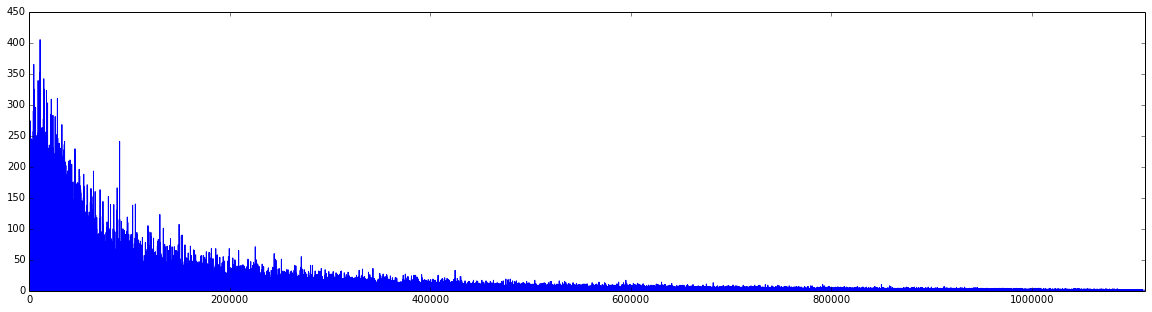

In [126]:
photo_train.exposure_num.plot(figsize=(20, 5))

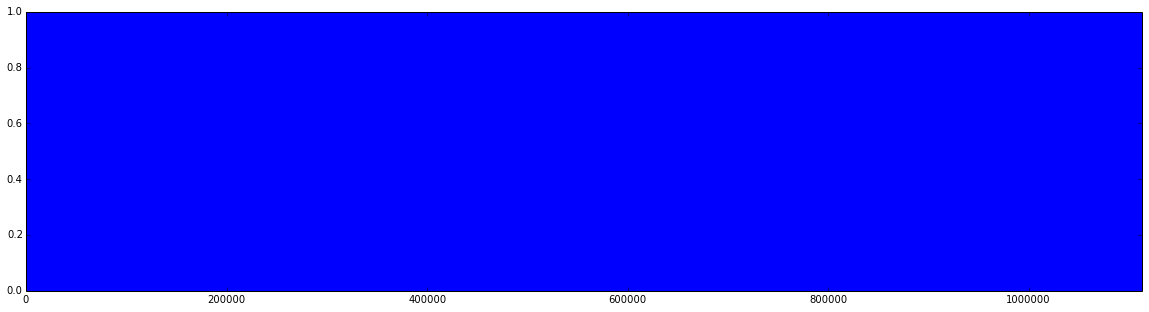

In [127]:
photo_train.clicked_ratio.plot(figsize=(20, 5))

In [128]:
photo_train.clicked_ratio.describe()

count    1.112781e+06
mean     1.354221e-01
std      3.000498e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: clicked_ratio, dtype: float64

In [129]:
photo_train.smooth_clicked_ratio.describe()

count    1.112781e+06
mean     2.477915e-01
std      4.097648e-02
min      2.020085e-02
25%      2.373536e-01
50%      2.373536e-01
75%      2.373536e-01
max      6.050367e-01
Name: smooth_clicked_ratio, dtype: float64

In [132]:
# photo_test['clicked_ratio'] = np.exp(-photo_test['exposure_num'])* np.random.beta(alpha_item, beta_item, photo_test.shape[0])

/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [135]:
photo_test['clicked_ratio'] = np.random.beta(alpha_item, beta_item, photo_test.shape[0])

/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


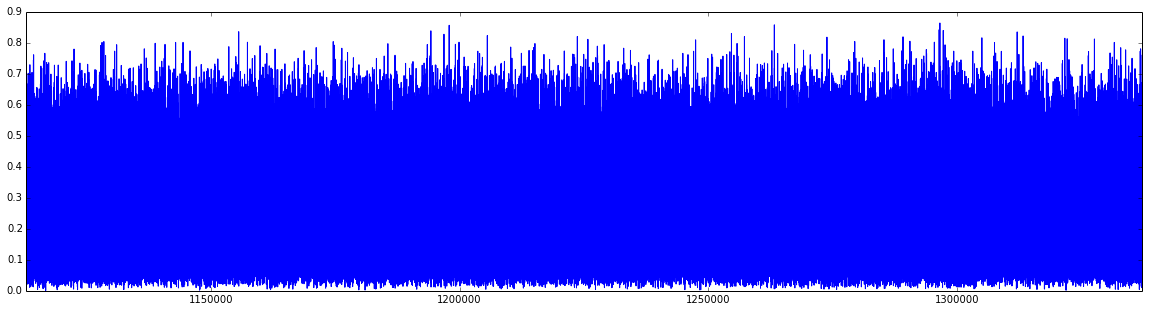

In [136]:
photo_test.clicked_ratio.plot(figsize=(20, 5))

In [76]:
from numpy.random import normal

sigma = 0.02966509
u = alpha_item/(alpha_item+beta_item)



In [77]:
import math
math.sqrt(sigma)

0.17223556543292678

In [78]:
photo_test['exposure_num_sigma'] = photo_test['exposure_num'].apply(lambda x: np.exp(-x) * sigma)

/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [79]:
photo_test['noise'] = photo_test['exposure_num_sigma'].apply(lambda x: normal(0, x))

/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [80]:
photo_test['clicked_ratio'] = u + photo_test['noise']

/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


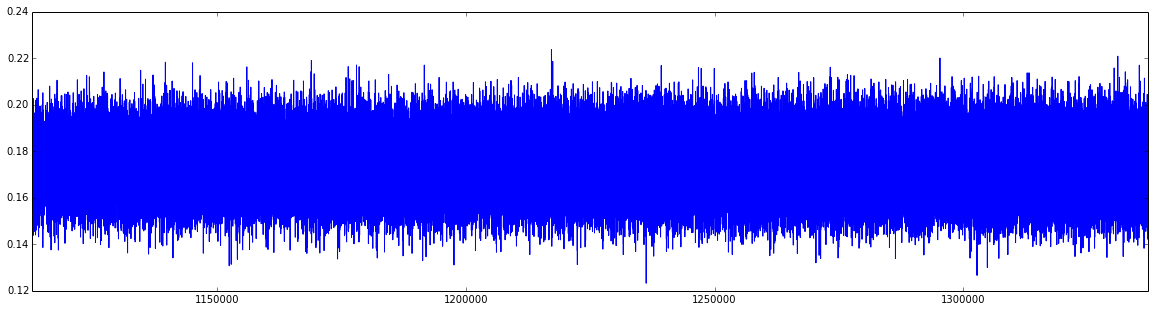

In [81]:
photo_test.clicked_ratio.plot(figsize=(20, 5))

In [ ]:
photo_test[photo_test['clicked_ratio']<0, ['clicked_ratio']] = 0

In [83]:
photo_test.clicked_ratio.describe()

count    224395.000000
mean          0.174487
std           0.009610
min           0.123255
25%           0.169223
50%           0.174497
75%           0.179730
max           0.223715
Name: clicked_ratio, dtype: float64

In [84]:
user_item_train.head()

,user_id,photo_id,click,like,follow,time,playing_time,duration_time
0,2,528031,0,0,0,761073153303,0,16
1,2,3141045,0,0,0,761073449279,0,10
2,2,6410672,0,0,0,761072688657,0,13
3,2,6031965,0,0,0,761079542559,0,11
4,2,492513,0,0,0,761071781792,0,11


In [85]:
photo_train.head()

,photo_id,exposure_num,duration_time,time,clicked_num,liked_num,followed_num,played_sum,duration_sum,clicked_ratio,liked_ratio,followed_ratio,played_ratio,smooth_clicked_ratio
0,528031,52,16.0,7.610732e+11,14.0,0.0,0.0,205.0,832.0,0.269231,0.000000,0.000000,0.246394,0.246847
1,3141045,189,10.0,7.610734e+11,63.0,1.0,0.0,728.0,1890.0,0.333333,0.005291,0.000000,0.385185,0.320874
2,6410672,157,13.0,7.610727e+11,33.0,0.0,1.0,465.0,2041.0,0.210191,0.000000,0.006369,0.227829,0.206873
3,6031965,8,11.0,7.610795e+11,1.0,0.0,0.0,7.0,88.0,0.125000,0.000000,0.000000,0.079545,0.158058
4,492513,1,11.0,7.610718e+11,0.0,0.0,0.0,0.0,11.0,0.000000,0.000000,0.000000,0.000000,0.164285


In [86]:
photo_train['clicked_ratio'] = photo_train['smooth_clicked_ratio']


/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [87]:
clicked_ratio_col_train = pd.merge(user_item_train[['user_id', 'photo_id']], photo_train[['photo_id', 'clicked_ratio']],
                                  how='left',
                                  on=['photo_id'])

In [88]:
clicked_ratio_col_train.head()

,user_id,photo_id,clicked_ratio
0,2,528031,0.246847
1,2,3141045,0.320874
2,2,6410672,0.206873
3,2,6031965,0.158058
4,2,492513,0.164285


In [89]:
clicked_ratio_col_train.to_csv(os.path.join(col_feature_store_path, 'clicked_ratio_train.csv'), sep='\t', index=False)

In [137]:
photo_test.head()

,photo_id,exposure_num,duration_time,time,clicked_num,liked_num,followed_num,played_sum,duration_sum,clicked_ratio,liked_ratio,followed_ratio,played_ratio,smooth_clicked_ratio
1112781,8493743,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.421666,NaN,NaN,NaN,NaN
1112782,8676804,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.321698,NaN,NaN,NaN,NaN
1112783,8389617,165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.482907,NaN,NaN,NaN,NaN
1112784,9080838,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.277770,NaN,NaN,NaN,NaN
1112785,8962078,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.131625,NaN,NaN,NaN,NaN


In [138]:
clicked_ratio_col_test = pd.merge(user_item_test[['user_id', 'photo_id']], photo_test[['photo_id', 'clicked_ratio']],
                                  how='left',
                                  on=['photo_id'])

In [139]:
clicked_ratio_col_test.head()

,user_id,photo_id,clicked_ratio
0,2,8493743,0.421666
1,2,8676804,0.321698
2,2,8389617,0.482907
3,2,9080838,0.277770
4,2,8962078,0.131625


In [140]:
clicked_ratio_col_test.to_csv(os.path.join(col_feature_store_path, 'clicked_ratio_test.csv'), sep='\t', index=False)

In [94]:
clicked_num_train = pd.merge(user_item_train[['user_id', 'photo_id']], photo_train[['photo_id', 'clicked_num']],
                            how='left',
                            on=['photo_id'])

In [95]:
clicked_num_train.to_csv(os.path.join(col_feature_store_path, 'clicked_num_train.csv'), sep='\t', index=False)

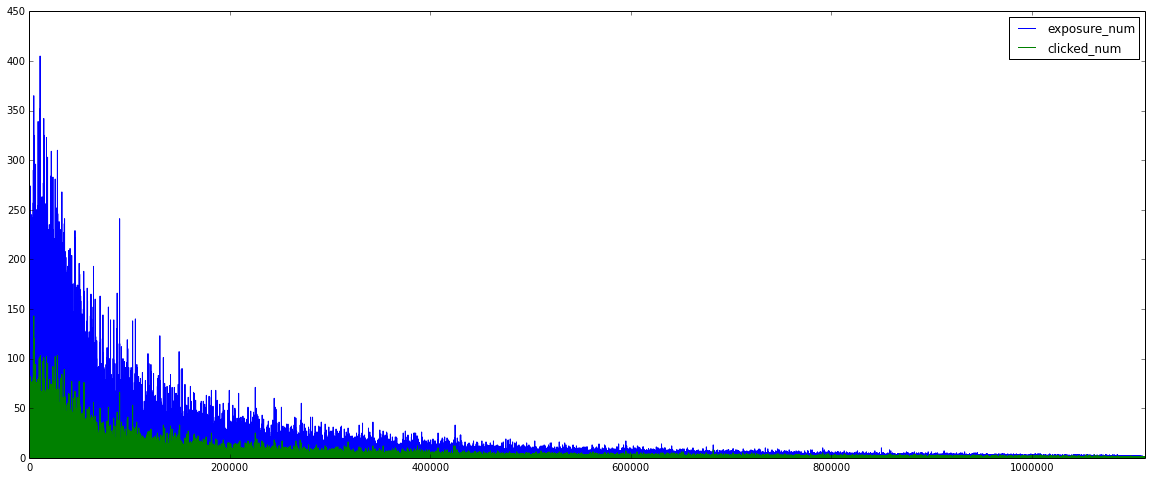

In [96]:
photo_train[['exposure_num',  'clicked_num']].plot(figsize=(20,8), kind='line')

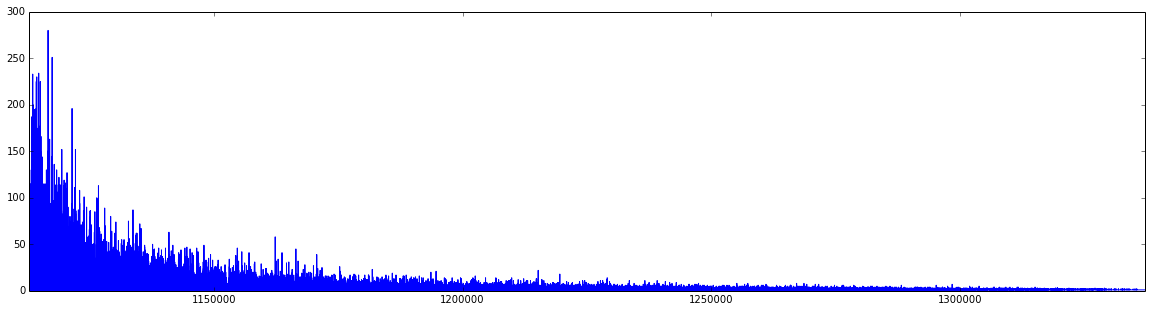

In [97]:
photo_test.exposure_num.plot(figsize=(20, 5))

In [98]:
np.sum(photo_train['clicked_num']==0)

865543

In [99]:
from scipy.stats import spearmanr

corrscore = spearmanr(photo_train['clicked_num'], photo_train['exposure_num'])
print('clicked_num - exposure_num: %s' % (str(corrscore)))

clicked_num - exposure_num: SpearmanrResult(correlation=0.5279037762643057, pvalue=0.0)


In [100]:
corrscore = spearmanr(photo_train['clicked_ratio'], photo_train['exposure_num'])
print('clicked_ratio - exposure_num: %s' % (str(corrscore)))

clicked_ratio - exposure_num: SpearmanrResult(correlation=-0.027222535868907417, pvalue=2.031908949218776e-181)


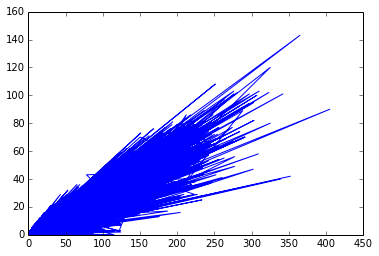

In [101]:
plt.figure()
plt.plot(photo_train['exposure_num'].values, photo_train['clicked_num'].values)

In [102]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
X = photo_train['exposure_num'].values.reshape((-1,1))
y = photo_train['clicked_num'].values.reshape((-1,1))
clf.fit(X, y)

/Library/Python/2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [103]:
photo_test['clicked_num'] = clf.predict(photo_test['exposure_num'].values.reshape((-1,1)))

/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [104]:
photo_test[photo_test['clicked_num'] < 0]['clicked_num'] = 0

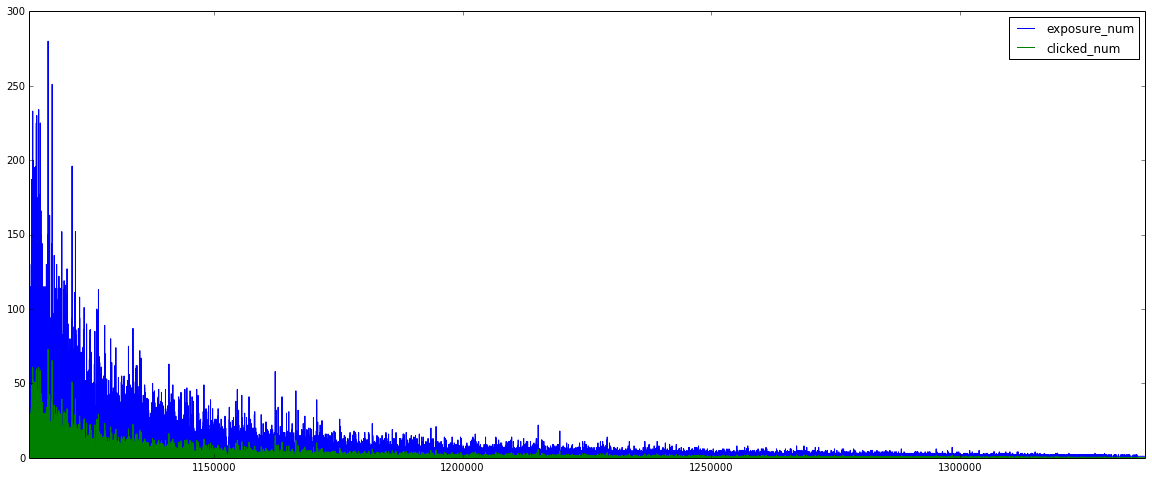

In [105]:
photo_test[['exposure_num',  'clicked_num']].plot(figsize=(20,8), kind='line')

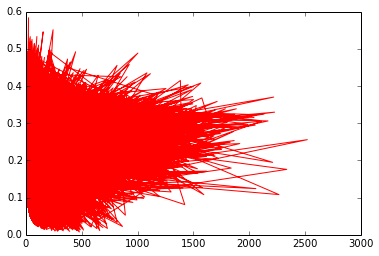

In [94]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.color'] = 'r'
mpl.rcParams['agg.path.chunksize'] = 100000

plt.figure()
plt.plot(photo_train['exposure_num'].values, photo_train['clicked_ratio'].values, color='red')

In [97]:
# 对用户点击率做贝叶斯平滑
I, C = photo_test['exposure_num'].values, photo_test['clicked_num'].values
#bs.update(I, C, 10000, 0.0000000001)
#print(bs.alpha, bs.beta)
#alpha_item, beta_item = bs.alpha, bs.beta
alpha_item, beta_item = 2.8072236088257325, 13.280311727786964
ctr = []
for i in range(len(I)):
    ctr.append((C[i]+alpha_item)/(I[i]+alpha_item+beta_item))
photo_test['clicked_ratio'] = ctr


/Library/Python/2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [98]:
alpha_item/(alpha_item+beta_item)

0.17449681073501258

In [99]:
# photo_data.clicked_ratio.fillna(alpha_item/(alpha_item+beta_item), inplace=True)

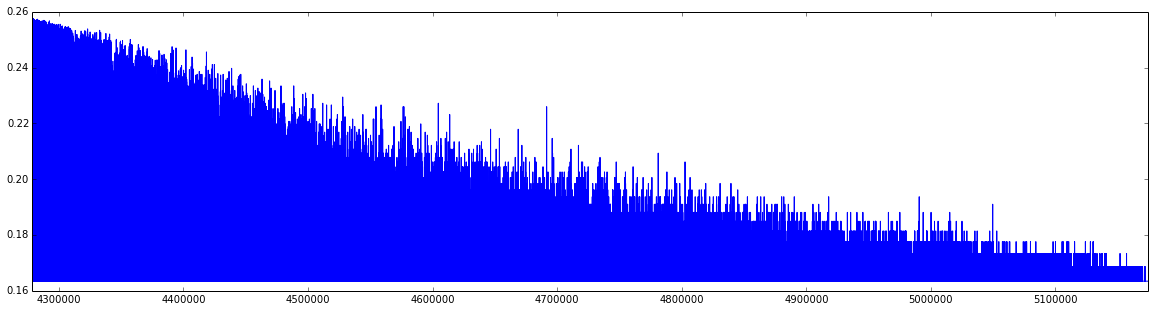

In [100]:
photo_test.clicked_ratio.plot(figsize=(20, 5))

In [199]:
np.sum(photo_data.clicked_ratio.isnull())

0

In [200]:
def exposure_time_diff(group):
#     print(group.head())
    m1, m2 = group.min(), group.max()
    return (m2 - m1) / 1000

In [201]:
# user_train, user_test = user_item_train[common], user_item_test[common]

# user_item_data = pd.concat([user_train, user_test])
# photo_data = pd.DataFrame()
# photo_data['photo_id'] = user_item_data['photo_id']
# photo_data['exposure_num'] = user_item_data['photo_id'].groupby(user_item_data['photo_id']).transform('count') 
# photo_data['exposure_time_diff'] = user_item_data['time'].groupby(user_item_data['photo_id']).transform(exposure_time_diff)
# photo_data.drop_duplicates(inplace=True)


# photo_data['exposure_freq'] = photo_data['exposure_num'] / photo_data['exposure_time_diff']

# photo_data.drop(['exposure_num'], axis=1, inplace=True)

In [202]:
photo_data.head(20)

,photo_id,exposure_num,duration_time,time,clicked_num,liked_num,followed_num,played_sum,duration_sum,clicked_ratio,liked_ratio,followed_ratio,played_ratio
0,6484142,13,11.0,7.610366e+11,5.0,0.0,0.0,34.0,143.0,0.268404,0.000000,0.000000,0.237762
1,4647664,2,11.0,7.610355e+11,1.0,0.0,0.0,12.0,22.0,0.210489,0.000000,0.000000,0.545455
2,4994626,34,10.0,7.610369e+11,9.0,0.0,0.0,72.0,340.0,0.235732,0.000000,0.000000,0.211765
3,4416881,1,9.0,7.611192e+11,0.0,0.0,0.0,0.0,9.0,0.164285,0.000000,0.000000,0.000000
4,2597756,2,11.0,7.611194e+11,0.0,0.0,0.0,0.0,22.0,0.155202,0.000000,0.000000,0.000000
5,4977481,155,11.0,7.610347e+11,71.0,0.0,0.0,744.0,1705.0,0.431400,0.000000,0.000000,0.436364
6,5089000,852,10.0,7.610358e+11,366.0,14.0,3.0,2922.0,8520.0,0.424850,0.016432,0.003521,0.342958
7,693195,55,11.0,7.610350e+11,18.0,0.0,0.0,173.0,605.0,0.292699,0.000000,0.000000,0.285950
8,163901,265,17.0,7.610344e+11,101.0,1.0,0.0,1244.0,4505.0,0.369306,0.003774,0.000000,0.276138
9,6472236,1,7.0,7.610357e+11,0.0,0.0,0.0,0.0,7.0,0.164285,0.000000,0.000000,0.000000


In [203]:
photo_data = pd.merge(photo_data, text_data,
                     how='left',
                     on='photo_id')

In [204]:
photo_data.head()

,photo_id,exposure_num,duration_time,time,clicked_num,liked_num,followed_num,played_sum,duration_sum,clicked_ratio,liked_ratio,followed_ratio,played_ratio,cover_words,cover_length
0,6484142,13,11.0,7.610366e+11,5.0,0.0,0.0,34.0,143.0,0.268404,0.0,0.0,0.237762,"[229, 56]",2
1,4647664,2,11.0,7.610355e+11,1.0,0.0,0.0,12.0,22.0,0.210489,0.0,0.0,0.545455,"[17874, 14, 73, 29, 143, 1117, 14, 93]",8
2,4994626,34,10.0,7.610369e+11,9.0,0.0,0.0,72.0,340.0,0.235732,0.0,0.0,0.211765,"[87420, 30620, 15258]",3
3,4416881,1,9.0,7.611192e+11,0.0,0.0,0.0,0.0,9.0,0.164285,0.0,0.0,0.000000,[],0
4,2597756,2,11.0,7.611194e+11,0.0,0.0,0.0,0.0,22.0,0.155202,0.0,0.0,0.000000,[],0


In [205]:
def exposure_num_discretization(exposure_num):
    if 0 < exposure_num and exposure_num <= 10:
        return 0
    elif 10 < exposure_num and exposure_num <= 100:
        return 1
    elif 100 < exposure_num and exposure_num <= 1000:
        return 2
    else:
        return 3

In [206]:
def clicked_ratio_discretization(num):
    if 0 <= num <= 0.06:
        return 0
    elif 0.06 < num <= 0.12:
        return 1
    elif 0.12 < num <= 0.2:
        return 2
    elif 0.2 < num <= 0.3:
        return 3
    else:
        return 4

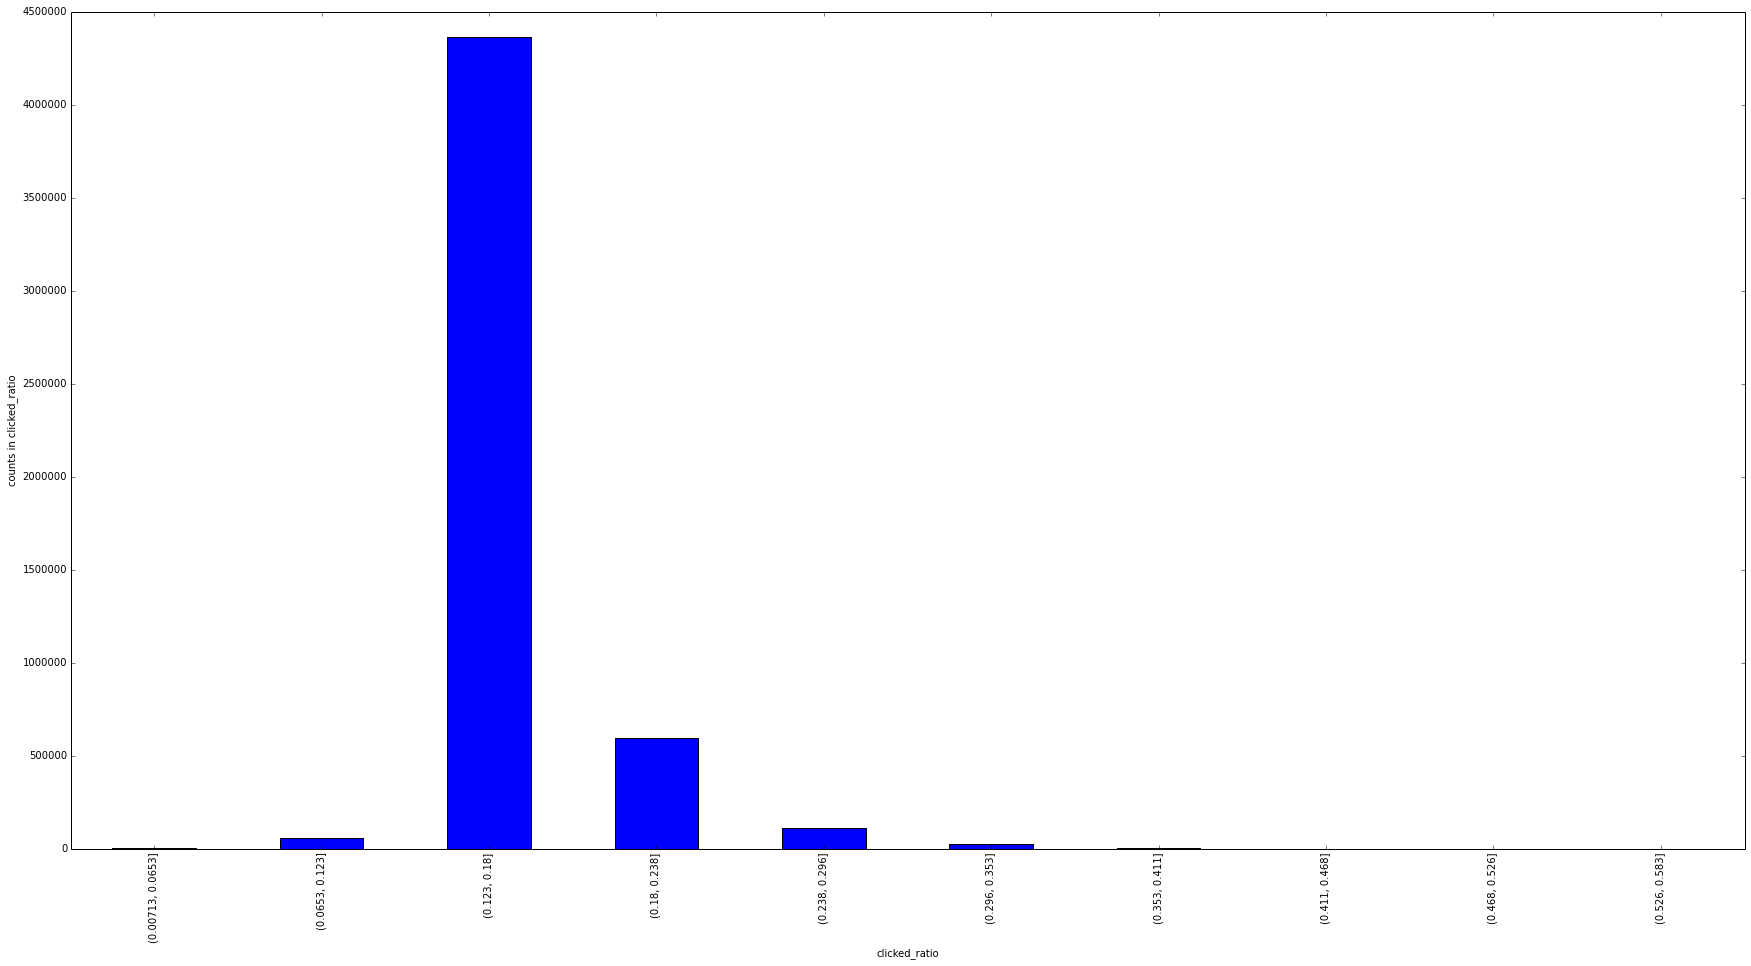

In [207]:
plot_data_cut(photo_data, 'clicked_ratio', 10)

In [208]:
def cover_length_discretization(num):
    if num == 0:
        return 0
    elif 0 < num <= 3:
        return 1
    elif 3 < num <= 10:
        return 2
    elif 10 < num <= 20:
        return 3
    else:
        return 4

In [209]:
photo_data.head()

,photo_id,exposure_num,duration_time,time,clicked_num,liked_num,followed_num,played_sum,duration_sum,clicked_ratio,liked_ratio,followed_ratio,played_ratio,cover_words,cover_length
0,6484142,13,11.0,7.610366e+11,5.0,0.0,0.0,34.0,143.0,0.268404,0.0,0.0,0.237762,"[229, 56]",2
1,4647664,2,11.0,7.610355e+11,1.0,0.0,0.0,12.0,22.0,0.210489,0.0,0.0,0.545455,"[17874, 14, 73, 29, 143, 1117, 14, 93]",8
2,4994626,34,10.0,7.610369e+11,9.0,0.0,0.0,72.0,340.0,0.235732,0.0,0.0,0.211765,"[87420, 30620, 15258]",3
3,4416881,1,9.0,7.611192e+11,0.0,0.0,0.0,0.0,9.0,0.164285,0.0,0.0,0.000000,[],0
4,2597756,2,11.0,7.611194e+11,0.0,0.0,0.0,0.0,22.0,0.155202,0.0,0.0,0.000000,[],0


In [210]:
photo_data[photo_data['cover_length']>30].shape

(5733, 15)

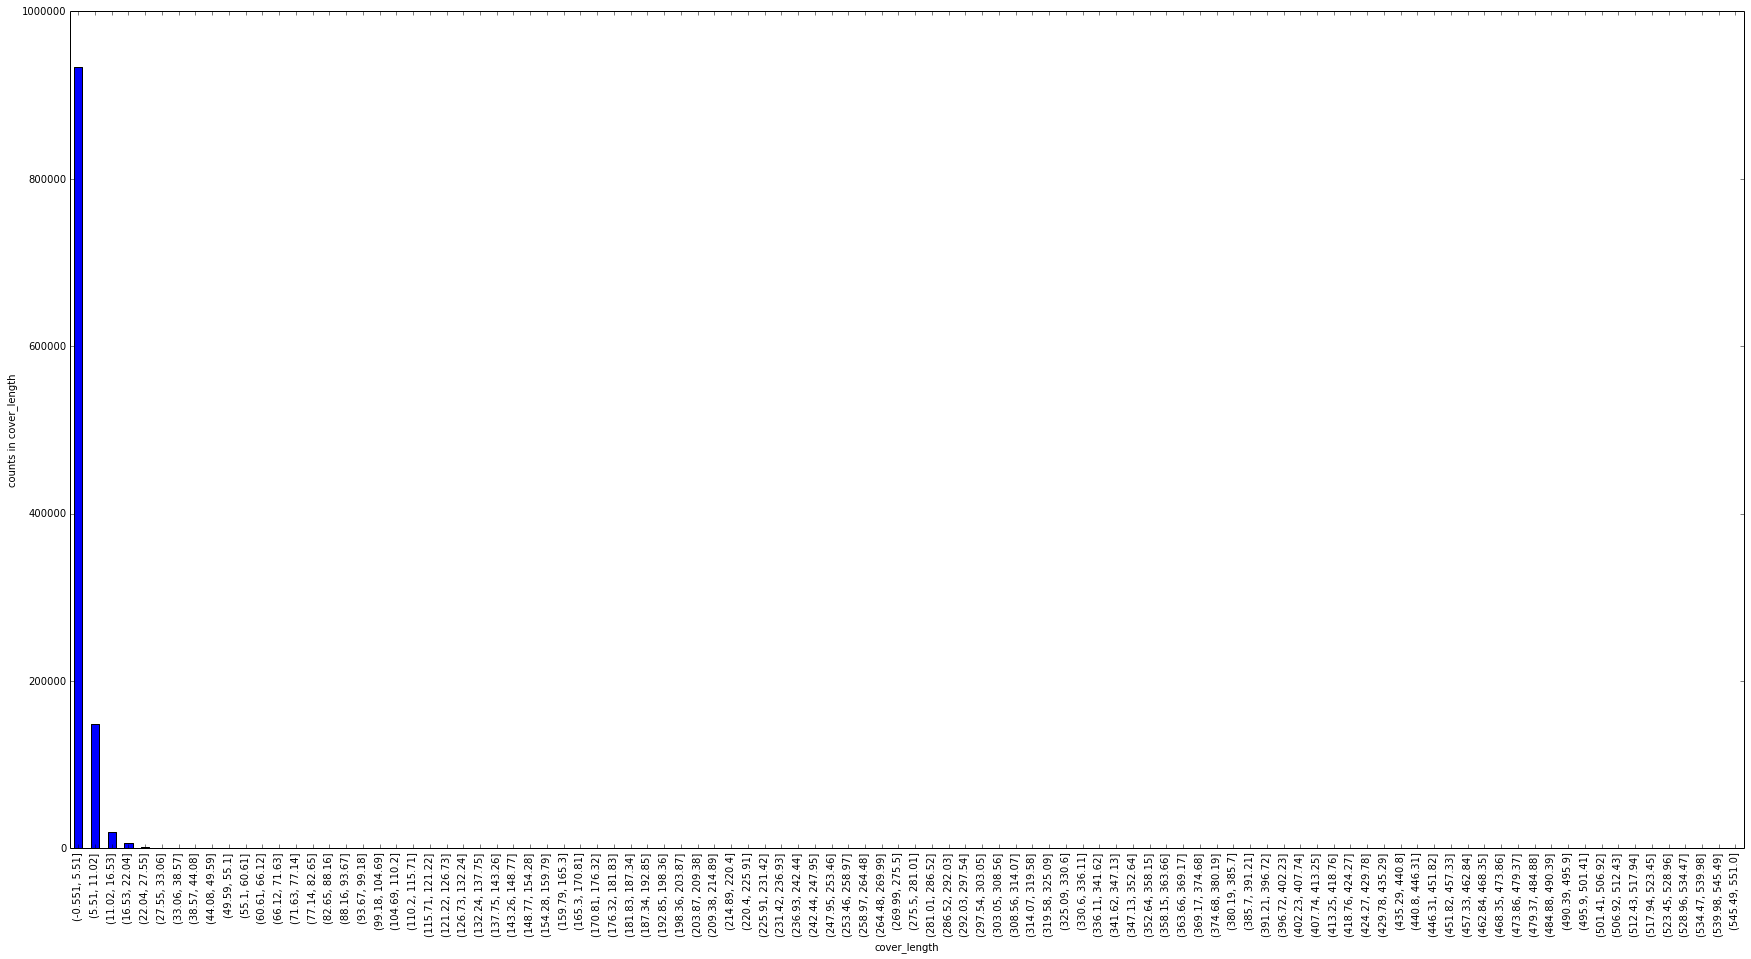

In [75]:
plot_data_cut(photo_data, 'cover_length', 100)

In [76]:
user_item_train = pd.merge(user_item_train, photo_data,
                              how='left',
                              on=['photo_id'])

In [77]:
# 用户点击视频中对人脸和颜值以及年龄的偏好，以后考虑离散化
favor_cols = ['cover_length']
favors = user_item_train.loc[user_item_train['click']==1, favor_cols+['user_id']]

# 文本平均长度作为偏爱率
favors['cover_length_favor'] = favors['cover_length'].groupby(favors['user_id']).transform('mean')

favors.drop_duplicates(['user_id'], inplace=True)
favors.drop(favor_cols, axis=1, inplace=True)
favors.reset_index(drop=True, inplace=True)


In [ ]:
def cover_length_favor_discretization(num):
    if num == 0:
        return 0
    elif 0 < num <= 3:
        return 1
    elif 3 < num <= 10:
        return 2
    else:
        return 3

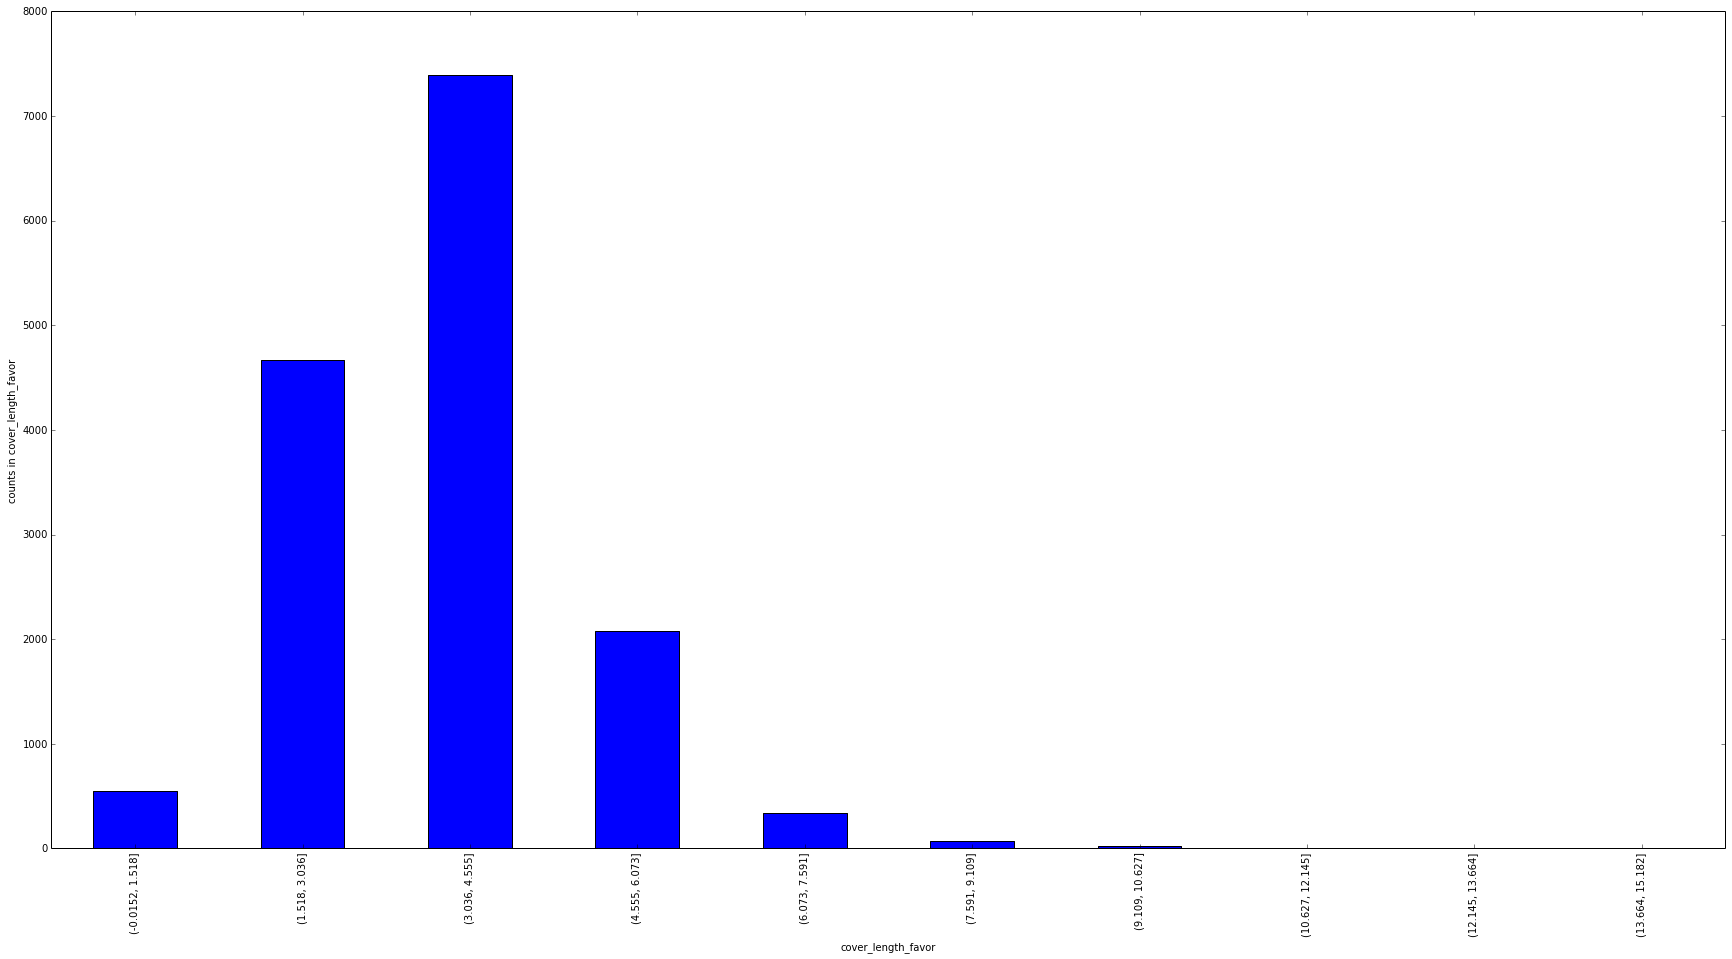

In [82]:
plot_data_cut(favors, 'cover_length_favor', 10)

In [89]:
bs = BayesianSmoothing(1, 1)
I, C = items['exposure_num'].values, items['clicked_num'].values
bs.update(I, C, 1000, 0.0000000001)
print(bs.alpha, bs.beta)
alpha, beta = bs.alpha, bs.beta
ctr = []
for i in range(len(I)):
    ctr.append((C[i]+alpha)/(I[i]+alpha+beta))
items['smooth_clicked_ratio'] = ctr

(2.8072236088257325, 13.280311727786964)


In [92]:
2.8/(2.8+13.2)

0.175